In [55]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import scipy
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

import os
from matplotlib.colors import TwoSlopeNorm

In [56]:
mer_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/mer_tropical_box.nc')
sst_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/sst_daily_tropical_band_1998_2022.nc')
vimfc_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/vimfc_tropical_box.nc')
viqtend_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/viqtend_tropical_box.nc')
T_P_tropical_box = xr.open_dataarray('/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/ERA5_Tropical_Box/T_P_tropical_box.nc')
mer_tropical_box = -mer_tropical_box
viqtend_tropical_box = -viqtend_tropical_box
T_P_tropical_box = -T_P_tropical_box
vimfc_tropical_box = -vimfc_tropical_box
T_P_tropical_box = -T_P_tropical_box
vimfc_tropical_box = -vimfc_tropical_box

In [57]:
def create_climatology_dataset(clim_365, clim_366, lat, lon, start_year=1998, end_year=2022):
    """
    Create a multi-annual dataset from two climatology NumPy arrays:
    - clim_365: climatology for common years (365 days)
    - clim_366: climatology for leap years (366 days)
    
    Parameters:
    -----------
    clim_365 : numpy.ndarray
        Array with shape (365, len(lat), len(lon)) for common years
    clim_366 : numpy.ndarray
        Array with shape (366, len(lat), len(lon)) for leap years
    lat : numpy.ndarray
        Latitude values
    lon : numpy.ndarray
        Longitude values
    start_year : int
        First year of the time series
    end_year : int
        Last year of the time series
    
    Returns:
    --------
    xarray.Dataset: Dataset with daily values for the specified period
    """
    # Verify input shapes
    assert clim_365.shape[0] == 365, "First dimension of clim_365 should be 365"
    assert clim_366.shape[0] == 366, "First dimension of clim_366 should be 366"
    assert clim_365.shape[1] == len(lat), "Second dimension of clim_365 should match length of lat"
    assert clim_365.shape[2] == len(lon), "Third dimension of clim_365 should match length of lon"
    assert clim_366.shape[1] == len(lat), "Second dimension of clim_366 should match length of lat"
    assert clim_366.shape[2] == len(lon), "Third dimension of clim_366 should match length of lon"
    
    # Create date range for the entire period
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Calculate total number of days
    total_days = len(dates)
    
    # Create an empty array to store the full time series data
    data = np.zeros((total_days, len(lat), len(lon)))
    
    # Current index in the data array
    idx = 0
    
    # Fill the data array year by year
    for year in range(start_year, end_year + 1):
        # Check if it's a leap year
        is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
        
        if is_leap_year:
            # Use 366-day climatology
            year_data = clim_366
            days_in_year = 366
        else:
            # Use 365-day climatology
            year_data = clim_365
            days_in_year = 365
        
        # Copy data for this year
        data[idx:idx+days_in_year] = year_data
        
        # Update index
        idx += days_in_year
    
    # Create xarray DataArray
    da = xr.DataArray(
        data=data,
        dims=('time', 'latitude', 'longitude'),
        coords={
            'time': dates,
            'latitude': lat,
            'longitude': lon
        },
        attrs={
            'long_name': 'Climatology Data',
            'units': 'unknown'
        }
    )
    
    # Convert to Dataset
    ds = da.to_dataset(name='daily_anomaly')
    
    # Add global attributes
    ds.attrs['title'] = f'Daily climatology for {start_year}-{end_year}'
    ds.attrs['source'] = 'Created from 365-day and 366-day climatology data'
    ds.attrs['creation_date'] = pd.Timestamp.now().strftime('%Y-%m-%d')
    
    return ds

In [58]:
# Example usage
if __name__ == "__main__":
    # These would be your actual arrays
    # Example dimensions for illustration
    
    # Create the dataset
    ds = create_climatology_dataset(daily_climatology_np_non_leap, daily_climatology_np_leap, mer_tropical_box.latitude, mer_tropical_box.longitude, 1998, 2022)
    
    ds

In [59]:
ds

<xarray.Dataset>
Dimensions:        (time: 9131, latitude: 21, longitude: 81)
Coordinates:
  * time           (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2022-12-31
  * latitude       (latitude) float32 -20.0 -19.75 -19.5 ... -15.5 -15.25 -15.0
  * longitude      (longitude) float32 150.0 150.2 150.5 ... 169.5 169.8 170.0
Data variables:
    daily_anomaly  (time, latitude, longitude) float64 6.256e-05 ... 4.805e-05
Attributes:
    title:          Daily climatology for 1998-2022
    source:         Created from 365-day and 366-day climatology data
    creation_date:  2025-05-04

In [60]:
anomaly_nino34_area = mer_tropical_box - ds

In [61]:
anomaly_nino34_area

<xarray.Dataset>
Dimensions:        (time: 9131, latitude: 21, longitude: 81)
Coordinates:
  * time           (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2022-12-31
  * latitude       (latitude) float32 -20.0 -19.75 -19.5 ... -15.5 -15.25 -15.0
  * longitude      (longitude) float32 150.0 150.2 150.5 ... 169.5 169.8 170.0
Data variables:
    daily_anomaly  (time, latitude, longitude) float64 2.441e-05 ... 1.369e-05

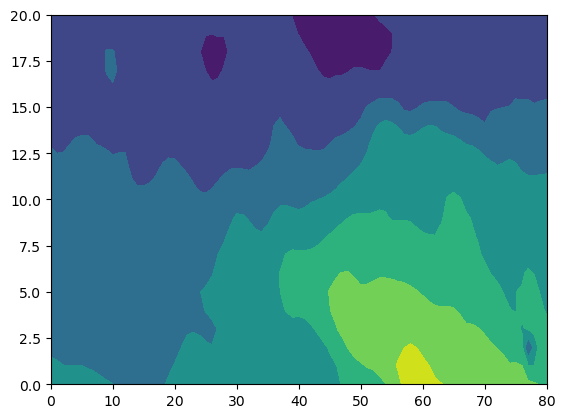

In [62]:
plt.contourf(anomaly_nino34_area.daily_anomaly[0, :, :])